In [1]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first

os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')

In [2]:
!cat  /g/data/xv83/rxm599/richard2.sh

#!/bin/bash
#
# change the parameter value for zoo and phyto plankton mortality

# first make muepbio=0
ncap2 -O -s "muepbio=muepbio*0" bgc_param.nc new.nc 

pds=(0 0.001 0.0083 0.05 0.0675 0.0833 0.125 0.15 0.2 0.25 0.3 0.35 0.5 )
zd=( 0 0.085 0.113 0.17 0.34 0.68 1.02 1.36 1.7 )

k=0
for (( i=1; i<=12; ++i)) ; do
for (( j=1; j<=8; ++j)) ; do
	k=$(( k + 1 ))
	echo $i,$j
	memstr=`printf "mem%03d" $k`
	echo $memstr
	echo  ${pds[$i]},  ${zd[$j]}
	ncap2 -O -s  "muezbio = muezbio*0 +${zd[$j]}/86400" -s "muepsbio=muepsbio*0 + ${pds[$i]}/86400" new.nc $memstr.nc 
done
done

 for (( mem = 1; mem <= 96; ++mem )); do
	memstr=`printf "mem%03d" $mem`
	echo copy $memstr
	rm ../enkf-bgc5/$memstr/INPUT/bgc_param.nc
	cp $memstr.nc ../enkf-bgc5/$memstr/INPUT/bgc_param.nc 
 done



In [36]:
# Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,memory="16GB")
client = Client(cluster)
cluster.scale(cores=16)
#cluster.adapt(minimum=2, maximum=16)
client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39713 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/39713/status,
Dashboard: /proxy/39713/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.133:44779,Workers: 0
Dashboard: /proxy/39713/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/35393/status,
Dashboard: /proxy/35393/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.133:35367,Workers: 0
Dashboard: /proxy/35393/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
#cluster.scale(cores=2)##

In [37]:
cluster

### Reminder for units

In [7]:
d=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip',consolidated=True)
for i in d.variables:
    if len(i)<8:
        t='\t\t'
    else:#if len(i)<13:
        t='\t'
    try:
        print(i+t+d[i].units)
    except:
        print(i+t+'no units')

adic		mmol/m^3
alk		mmol/m^3
caco3		mmol/m^3
caco3_sediment	mmolN/m^2
det		mmol/m^3
det_sediment	mmolN/m^2
dic		mmol/m^3
ensemble	no units
export_inorg	mmolC/m^2/s
export_prod	mmolN/m^2/s
fe		mmol/m^3
no3		mmol/m^3
o2		mmol/m^3
paco2		
pco2		
phy		mmol/m^3
pprod_gross	mmolN/m^3/s
pprod_gross_2d	mmolN/m^2/s
scalar_axis	none
st_ocean	meters
stf03		mmol/m^2/s
stf07		mmol/m^2/s
stf10		mmol/m^2/s
surface_adic	mmol/m^3
surface_alk	mmol/m^3
surface_caco3	mmol/m^3
surface_det	mmol/m^3
surface_dic	mmol/m^3
surface_fe	mmol/m^3
surface_no3	mmol/m^3
surface_o2	mmol/m^3
surface_phy	mmol/m^3
surface_zoo	mmol/m^3
time		no units
total_aco2_flux	Pg/yr
total_co2_flux	Pg/yr
xt_ocean	degrees_E
yt_ocean	degrees_N
zoo		mmol/m^3


## Load our data in

In [8]:
ls /g/data/xv83/dcfp/CAFE60v1/

atmos_isobaric_daily.zarr.zip*  ocean_daily.zarr.zip*
atmos_isobaric_month.zarr.zip*  ocean_ens_mean_at_analysis.zarr.zip*
ice_month.zarr.zip*             ocean_force_month.zarr.zip*
land_month.zarr.zip*            ocean_month.zarr.zip*
ocean_bgc_daily.zarr.zip*       ocean_scalar_month.zarr.zip*
ocean_bgc_month.zarr.zip*


In [9]:
a=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/atmos_isobaric_month.zarr.zip',consolidated=True)

In [10]:
a

,Array,Chunk
Bytes,71.15 GiB,99.67 MiB
Shape,"(731, 96, 21, 90, 144)","(1, 96, 21, 90, 144)"
Count,732 Tasks,731 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,3.39 GiB,4.75 MiB
Shape,"(731, 96, 90, 144)","(1, 96, 90, 144)"
Count,732 Tasks,731 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [11]:
ls ../processed_data/obs #../processed_data/eqpac/

landshutzer_eqpac_regrid.nc              rodenbeck_global_regrid_trend_2000.nc
landshutzer_eqpac_regrid_trend_1982.nc   rodenbeck_intermediate_regrid.nc
landshutzer_eqpac_regrid_trend_2000.nc   sst.mnmean.regrid.eqpac.nc
landshutzer_global_regrid.nc             sst.mnmean.regrid.eqpac.trend.1982.nc
landshutzer_global_regrid_trend_1982.nc  sst.mnmean.regrid.eqpac.trend.2000.nc
landshutzer_global_regrid_trend_2000.nc  sst.mnmean.regrid.global.nc
Nasa_merged_chlora_month_regrid.nc       sst.mnmean.regrid.global.trend.1982.nc
rodenbeck_eqpac_regrid.nc                sst.mnmean.regrid.global.trend.2000.nc
rodenbeck_eqpac_regrid_trend_1982.nc     TPCA_modis_month_regrid.nc
rodenbeck_eqpac_regrid_trend_2000.nc     TPCA_month_regrid.nc
rodenbeck_global_regrid.nc               TPCA_month_regrid_new1.nc
rodenbeck_global_regrid_trend_1982.nc    TPCA_sw_month_regrid.nc


In [12]:
!ls ../processed_data/cafe/ #../processed_data/eqpac/

currents  eqpac  global


In [13]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/35393/status,
Dashboard: /proxy/35393/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.133:35367,Workers: 0
Dashboard: /proxy/35393/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [14]:
cafe_co2_all=xr.open_dataset('../processed_data/cafe/eqpac/stf10_ensmean_1982_all_ensembles.nc',chunks={'time':1})#.chunk({'time':1})#/1000)*86400)*-12)#g/m2/day
cafe_co2_nat=xr.open_dataset('../processed_data/cafe/eqpac/stf07_ensmean_1982_all_ensembles.nc',chunks={'time':1})#.chunk({'time':1})#/1000)*86400)*-12)#g/m2/day
#cafe_co2_all=xr.open_dataset('../processed_data/cafe/eqpac/stf03_ensmean_1982_all_ensembles.nc',chunks={'time':1})#.chunk({'time':1})#/1000)*86400)*-12)#g/m2/day
cafe_sst_all=xr.open_dataset('../processed_data/cafe/eqpac/sst_ensmean_1982_all_ensembles.nc',chunks={'time':1})#.chunk({'time':1})

#cafe_co2_all_g=((cafe_co2_all/1000)*86400*-12) #g/m2/day #OLD
#cafe_co2_nat_g=((cafe_co2_nat/1000)*86400*-12) #g/m2/day #OLD

cafe_co2_all_g=((cafe_co2_all)*-86400) #g/m2/day
cafe_co2_nat_g=((cafe_co2_nat)*-86400) #g/m2/day


In [15]:
best_ensemble_member=25 # Calculated in 8: Get best ens members.
#Bring all the unit conversions here. 


phy_mean=xr.open_dataset('../processed_data/cafe/eqpac/phy_ensmean_1982_15m_.nc')
#phy_std=xr.open_dataset('../processed_data/eqpac/surface_phy_ensstd_1982.nc')
phy_trend82=xr.open_dataset('../processed_data/cafe/eqpac/phy_meantrends_1982_15m_.nc')
phy_trend20=xr.open_dataset('../processed_data/cafe/eqpac/phy_meantrends_2000_15m_.nc')

#pprod_std=xr.open_dataset('../processed_data/eqpac/pprod_gross_2d_ensstd../_1982.nc')
pprod_mean=xr.open_dataset('../processed_data/cafe/eqpac/pprod_gross_2d_ensmean_1982.nc')
pprod_trend82=xr.open_dataset('../processed_data/cafe/eqpac/pprod_gross_2d_meantrends_1982.nc')
pprod_trend20=xr.open_dataset('../processed_data/cafe/eqpac/pprod_gross_2d_meantrends_2000.nc')


#LOAD CAFE SST AND CO2 FLUX
cafe_sst_std=xr.open_dataset('../processed_data/cafe/global/sst_ensstd_1982.nc')
cafe_sst_mean=xr.open_dataset('../processed_data/cafe/global/sst_ensmean_1982.nc')
cafe_sst_82tr=xr.open_dataset('../processed_data/cafe/global/sst_meantrends_1982.nc')
cafe_sst_20tr=xr.open_dataset('../processed_data/cafe/global/sst_meantrends_2000.nc')


cafe_co2_std=xr.open_dataset('../processed_data/cafe/global/stf10_ensstd_1982.nc')
cafe_co2_mean=xr.open_dataset('../processed_data/cafe/global/stf10_ensmean_1982.nc')
cafe_co2_82tr=xr.open_dataset('../processed_data/cafe/global/stf10_meantrends_1982.nc')
cafe_co2_20tr=xr.open_dataset('../processed_data/cafe/global/stf10_meantrends_2000.nc')


#Load CO2 and SST OBS PRODUCTS
land_co2=(xr.open_dataset('../processed_data/obs/landshutzer_global_regrid.nc')*1000/12)/365 #g/m2/day  # To mmol/m2/day
land_co2_82tr=xr.open_dataset('../processed_data/obs/landshutzer_global_regrid_trend_1982.nc')
land_co2_20tr=xr.open_dataset('../processed_data/obs/landshutzer_global_regrid_trend_2000.nc')

rodenbeck_co2=(xr.open_dataset('../processed_data/obs/rodenbeck_global_regrid.nc')*1000/12)#/365  # To mmol/m2/day
rodenbeck_co2_82tr=xr.open_dataset('../processed_data/obs/rodenbeck_global_regrid_trend_1982.nc')
rodenbeck_co2_20tr=xr.open_dataset('../processed_data/obs/rodenbeck_global_regrid_trend_2000.nc')
# #/(10**15/365) #Convert from PgC/Yr to gC/day


rey_sst=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.nc')
rey_sst_82tr=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.trend.1982.nc')
rey_sst_20tr=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.trend.2000.nc')

## Phytoplankton test in progress

In [16]:
#rodenbeck_co2=xr.open_dataset('../processed_data/obs/rodenbeck_global_regrid.nc')#/1000 *12

In [17]:
#land_co2=((xr.open_dataset('../processed_data/obs/landshutzer_global_regrid.nc')/365)*1000)/12#/1000*12 #g/m2/day 

#land_co2=(xr.open_dataset('../processed_data/obs/landshutzer_global_regrid.nc')*1000/12)/365 #g/m2/day
#land_co2.mean(dim=['lat','lon']).fgco2_smoothed.plot()

## Lets look at and compare model CO2 flux to Landshutzer (spatial)

What year has the Min or Max seasonality.

## Lets look at and compare model CO2 flux to Landshutzer (temporal)

0
cafe Co2 flux: 2.330737531731154
cafe Co2 Natural flux: 3.6135429671475223
land co2 flux: 2.465023373332266
Rodenbeck co2 flux: 3.174915786086897
Whole EqPac : -21.11117934059794% err Landschutzer
Whole EqPac : -35.82513891747062% err Rodenbeck
Whole EqPac : -1.079662461406762% err Landschutzer Ens25
Whole EqPac : -15.79362203827944% err Rodenbeck Ens25
1
cafe Co2 flux: 3.2774030642033387
cafe Co2 Natural flux: 4.672107169036713
land co2 flux: 3.7305356816656383
Rodenbeck co2 flux: 4.801616774942025
East EqPac : -23.858816984119084% err Landschutzer
East EqPac : -43.49364097035974% err Rodenbeck
East EqPac : -3.6881742001020874% err Landschutzer Ens25
East EqPac : -23.322998186342755% err Rodenbeck Ens25
2
cafe Co2 flux: 2.8881283376760885
cafe Co2 Natural flux: 4.223620445828534
land co2 flux: 2.9162854845961235
Rodenbeck co2 flux: 4.050891043614645
Central EqPac : -13.136532963445694% err Landschutzer
Central EqPac : -32.162113418682054% err Rodenbeck
Central EqPac : 10.09368498841

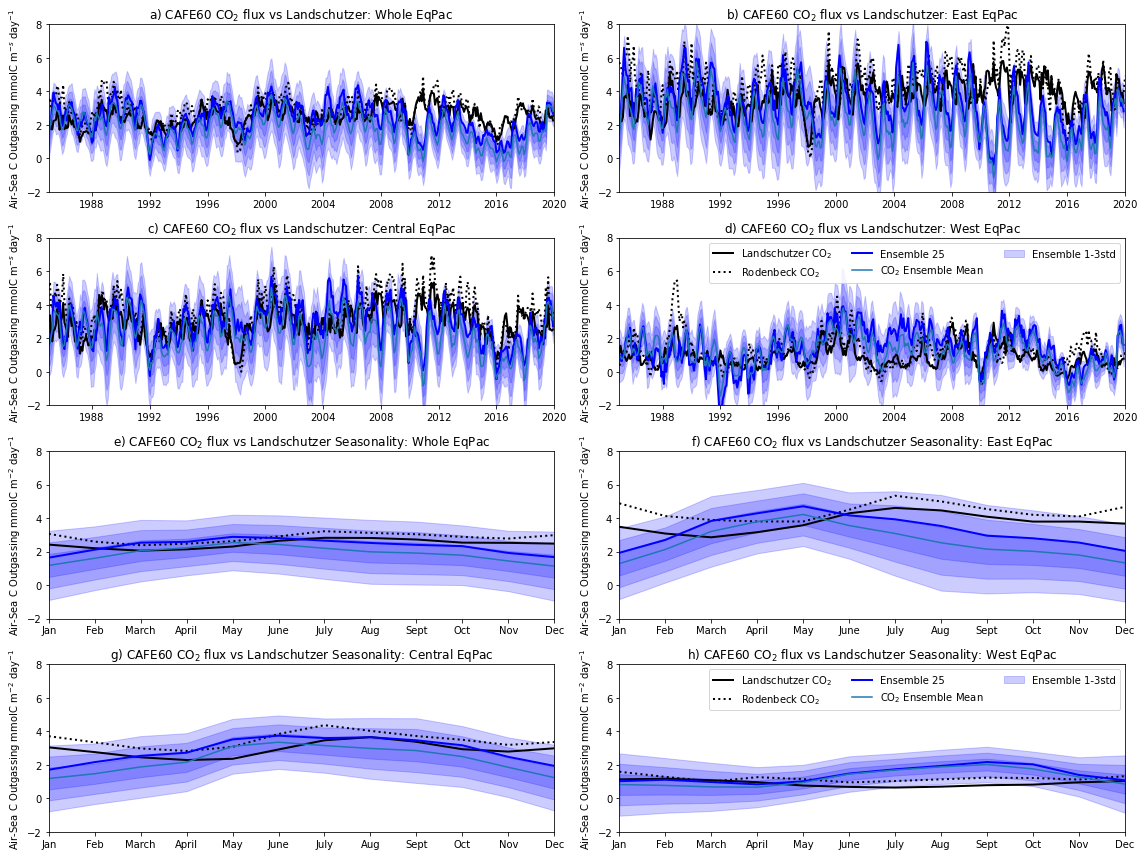

In [34]:
#Ok how does this error look through time for different parts of the Pacific.
letters=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o']

labels=['Whole EqPac',
        #'SouthEast EqPac',
        #'NorthEast EqPac',
        'East EqPac',
        'Central EqPac',
        'West EqPac']

locs=[[-15,15,150,275],
      #[-15,0,225,250],
      #[0,15,225,250],
      [-15,15,225,250],
      [-15,15,200,225],
      [-15,15,165,190]]
      #[-15,15,150,175]]
      
plt.figure(figsize=(16,12))#20,16))
#letters=['a','b','c']
all_err=[]
for i,latlon in enumerate(locs):
    print(i)
    #Conversion  #mmol/s to mol/s to mol/day to g/day and also invert for sea-air flux
    cafe_co2_std_reg=(cafe_co2_all_g).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).std(dim=['lat','lon'])
    cafe_co2_mean_reg=(cafe_co2_all_g).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    
    cafe_co2_nat_std_reg=(cafe_co2_nat_g).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).std(dim=['lat','lon'])
    cafe_co2_nat_mean_reg=(cafe_co2_nat_g).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    
    
    land_co2_std_reg=((land_co2.fgco2_smoothed)).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3]),time=slice(np.datetime64('1985-01-01'),np.datetime64('2020-01-01'))).std(dim=['lat','lon'])
    land_co2_mean_reg=((land_co2.fgco2_smoothed)).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3]),time=slice(np.datetime64('1985-01-01'),np.datetime64('2020-01-01'))).mean(dim=['lat','lon'])
    
    #rodenbeck_co2_f=rodenbeck_co2/(10**15/365)
    rodenbeck_co2_std_reg=((rodenbeck_co2.co2flux_ocean)).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).std(dim=['lat','lon'])#/2
    rodenbeck_co2_mean_reg=((rodenbeck_co2.co2flux_ocean)).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])#/2
    
    best_co2_ensemble=cafe_co2_mean_reg.stf10.sel(ensemble=best_ensemble_member)
    best_co2_nat_ensemble=cafe_co2_nat_mean_reg.stf07.sel(ensemble=best_ensemble_member)
    
    print('cafe Co2 flux: '+ str(best_co2_ensemble.mean(dim=['time']).values))
    print('cafe Co2 Natural flux: '+ str(best_co2_nat_ensemble.mean(dim=['time']).values))
    
    print('land co2 flux: '+str(land_co2_mean_reg.mean(dim=['time']).values))
    print('Rodenbeck co2 flux: '+str(rodenbeck_co2_mean_reg.mean(dim=['time']).values))
    
    #region_co2_path='../processed_data/co2_region_ens/co2_regional_ens_'+str(labels[i])+'.nc'
    #cafe_co2_mean_reg.to_netcdf(region_co2_path)
    
    err=cafe_co2_mean_reg.std(dim='ensemble').load()
    m=cafe_co2_mean_reg.mean(dim='ensemble').load()
    
   
    
    #if i==0:
    #    ax=plt.subplot(4,1,1)
    #else:
    #    ax=plt.subplot(4,3,3+i)
    ax=plt.subplot(4,2,i+1)
    ax.plot(land_co2_mean_reg.time,land_co2_mean_reg,c='k',linewidth=2)
    #if i==0:
    ax.plot(rodenbeck_co2_mean_reg.time,rodenbeck_co2_mean_reg,c='k',linewidth=2,linestyle=':')
    
        
        #ax.plot(cafe_co2_nat_mean_reg.time.values,best_co2_nat_ensemble,c='b',linewidth=2,linestyle="--")
    #  Plot the Seemingly most accurate CO2 flux ens member
    ax.plot(cafe_co2_mean_reg.time.values,best_co2_ensemble,c='b',linewidth=2)
        
    ax.plot(m.time,m.stf10)
    ax.fill_between(err.time.values,m.stf10+(err*1).stf10,m.stf10-(err*1).stf10,alpha=0.2,color='blue')
    ax.fill_between(err.time.values,m.stf10+(err*2).stf10,m.stf10-(err*2).stf10,alpha=0.2,color='blue')
    ax.fill_between(err.time.values,m.stf10+(err*3).stf10,m.stf10-(err*3).stf10,alpha=0.2,color='blue')

    #if i==0:
    if (i+1)%4==0:
        ax.legend(['Landschutzer CO$_{2}$','Rodenbeck CO$_{2}$','Ensemble 25','CO$_{2}$ Ensemble Mean', 'Ensemble 1-3std'],ncol=3) #,,'Ensemble 25 Natural CO$_{2}$'
    #else:
    #    ax.legend(['Landschutzer CO$_{2}$', 'CO$_{2}$ Ensemble Mean','Ensemble 1-3std']) #,
    #ax.legend(['Landschutzer CO2','Rodenbeck CO2','Ensemble 25','Ensemble 25 Natural CO2','1-3std'])
    ax.set_xlim([np.datetime64('1985-01-01'),np.datetime64('2020-01-01')])
    ax.set_ylabel('Air-Sea C Outgassing mmolC m$^{-s}$ day$^{-1}$')
    #ax.set_title('CO2 flux comparisons')
    ax.set_title(f'{letters[i]}) CAFE60 CO$_{2}$ flux vs Landschutzer: {labels[i]}')
    ax.set_ylim([-2,8])
    #ax.set_xlim([np.datetime64('1985-01-01'),np.datetime64('2020-01-01')])
    #Calculate biases
    
    #These biases might be backwards.
    perc_err=(((cafe_co2_mean_reg.stf10-land_co2_mean_reg)/land_co2_mean_reg)*100).mean(dim='time')
    perc_err2=(((cafe_co2_mean_reg.stf10-rodenbeck_co2_mean_reg)/land_co2_mean_reg)*100).mean(dim='time')
    
    
    bias=(cafe_co2_mean_reg.stf10-land_co2_mean_reg).mean(dim='time')
    mae=np.abs(cafe_co2_mean_reg.stf10-land_co2_mean_reg).mean(dim='time')
    print(labels[i]+' : '+str(perc_err.mean(dim='ensemble').values) + '% err Landschutzer')
    print(labels[i]+' : '+str(perc_err2.mean(dim='ensemble').values) + '% err Rodenbeck')
    
    print(labels[i]+' : '+str(perc_err.sel(ensemble=25).values) + '% err Landschutzer Ens25')
    print(labels[i]+' : '+str(perc_err2.sel(ensemble=25).values) + '% err Rodenbeck Ens25')
    
    perc_err.name='percenterr'
    bias.name='bias'
    mae.name='mae'
    err_stats=xr.merge([perc_err,bias,mae],compat='override')
    err_stats['region']=i
    err_stats['region_name']=labels[i]
    all_err.append(err_stats)
    
regional_err=xr.concat(all_err,dim='region')

#Where do we want to save results??
#regional_err.to_netcdf('/scratch1/pit071/CO2_flux_error.nc')
print(regional_err)
regional_err.to_netcdf('../processed_data/err/regional_co2_err.nc')


for i,latlon in enumerate(locs):
    print('starting '+str(latlon))
    cafe_seasonality=cafe_co2_all_g.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).stf10.groupby('time.month').mean()
    #cafe_seasonality_nat=cafe_co2_nat_g.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).stf07.groupby('time.month').mean()
 
    land_seasonality=land_co2.fgco2_smoothed.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3]),time=slice(np.datetime64('1985-01-01'),np.datetime64('2020-01-01'))).groupby('time.month').mean().mean(dim=['lat','lon'])
    rodenbeck_seasonality=(rodenbeck_co2.co2flux_ocean).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3]),time=slice(np.datetime64('1985-01-01'),np.datetime64('2020-01-01'))).groupby('time.month').mean().mean(dim=['lat','lon'])

    #if i==0:
    #    ax=plt.subplot(4,1,3)
    #else:
    #    ax=plt.subplot(4,3,9+i)
    ax=plt.subplot(4,2,5+i)    
    err=cafe_seasonality.std(dim='ensemble').mean(dim=['lat','lon']).load()
    m=cafe_seasonality.mean(['lat','lon','ensemble']).load()
    
    ax.plot(land_seasonality.month,land_seasonality,c='k',linewidth=2)
    ax.plot(rodenbeck_seasonality.month,rodenbeck_seasonality,c='k',linewidth=2,linestyle=':')
    
    # Plot the Seemingly most accurate CO2 flux ens member
    ax.plot(cafe_seasonality.month,cafe_seasonality.mean(['lat','lon']).sel(ensemble=best_ensemble_member),c='b',linewidth=2)
    #ax.plot(cafe_seasonality_nat.month,cafe_seasonality_nat.mean(['lat','lon']).sel(ensemble=best_ensemble_member),c='b',linewidth=2,linestyle="--")
    
    
    ax.plot(err.month,m)
    ax.fill_between(err.month,m+(err*1),m-(err*1),alpha=0.2,color='blue')
    ax.fill_between(err.month,m+(err*2),m-(err*2),alpha=0.2,color='blue')
    ax.fill_between(err.month,m+(err*3),m-(err*3),alpha=0.2,color='blue')

    #olc=clim.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    #olc['monthclim']=olc['monthclim']+1
    #ax.plot(olc.monthclim,olc,c='k',linewidth=2,linestyle='--')
    
    
    #Ok we could plot the individual lines using seaborn. 
    
    #land_seasonality=land_seasonality.to_dataframe().reset_index()
    #seasonal=cafe_seasonality.stf10.mean(dim=['lat','lon']).to_dataframe().reset_index()
    #sns.lineplot(data=seasonal,x='month',y='stf10',hue='ensemble',ax=ax)#,hue='ensemble')
    #sns.lineplot(data=land_seasonality,x='month',y='fgco2_smoothed',color='k',linewidth=3,ax=ax)#,hue='ensemble')
    ax.set_ylim([-2,8])
    ax.set_xlim([1,12])
    ax.set_ylabel('Air-Sea C Outgassing mmolC m$^{-2}$ day$^{-1}$')
    #ax.set_xlim([np.datetime64('1985-01-01'),np.datetime64('2020-01-01')])
    ax.set_title(f'{letters[4+i]}) CAFE60 CO$_{2}$ flux vs Landschutzer Seasonality: {labels[i]}')
    plt.xticks(ticks=np.arange(1,13,1),labels=['Jan','Feb','March','April','May','June','July', 'Aug','Sept','Oct','Nov', 'Dec'])
    if (i+1)%4==0:
        ax.legend(['Landschutzer CO$_{2}$','Rodenbeck CO$_{2}$','Ensemble 25','CO$_{2}$ Ensemble Mean', 'Ensemble 1-3std'],ncol=3) #, ,'Ensemble 25 Natural CO$_{2}$'
plt.tight_layout()
plt.show()

In [ ]:
regional_sst_err.sel(region=region).percenterr.to_series().plot.bar(ax=ax1,position=0,color='k',width=0.4)
ax1.set_ylabel('SST Percent Error', color='k') 
plt.ylim([-0.5,0.5])

ax2 = ax1.twinx() 
regional_err.sel(region=region).percenterr.to_series().plot.bar(ax=ax2,color='red',position=1,width=0.4)

## Lets use those biases that we created before

In [25]:
cafe_co2_mean_reg.stf10.sel(ensemble=25).mean(dim='time').values

array(1.39573579)

## Error

In [19]:
#Lets expand a bit further with calculating bias per pixel
#Calculate RMS and bias real quick... I say that but this might take a little while to process....  ()
#Might crash
# ------------------------------------------------
#Using the global / public vars here aha not good oh well.
def calculate_co2_err():
    model=cafe_co2_all_g.stf10#.mean(dim=['time','ensemble'])
    obs=land_co2.fgco2_smoothed#.mean(dim='time')

    diff=model-obs
    diff_log=np.log10(model)-np.log10(obs)
    bias=10**(diff_log)
    perc_err=((model-obs)/obs)*100
    rms=np.sqrt(diff**2)
    mae=np.abs(diff)

    perc_err.name='perc_err'
    rms.name='rms'
    bias.name='bias'
    diff.name='difference'
    mae.name='mae'

    all_error=xr.merge([perc_err,rms,bias,diff,mae])
    print(all_error.nbytes/1e9)
    all_error.to_netcdf('../processed_data/err/CO2_flux_allerror.nc')
    return True
#Combine these into a dataset and save? WHere are we saving the results?! Lets make some folders.
def mean_co2_err():
    err=xr.open_dataset('../processed_data/err/CO2_flux_allerror.nc',chunks='auto')
    err_tmean=err.mean(dim='time')
    err_tmean.to_netcdf('../processed_data/err/CO2_flux_meanerror.nc')

In [20]:
# calculate_co2_err() #Takes a long time lots of Ram? But works! Mean over time doesnt though hmm.
# mean_co2_err() #Hasnt been working. Perhaps due to chunking issues? # Seems to work now maybe need low load on the super computer.

In [29]:
regional_err.percenterr.sel(ensemble=25,region=0).values

array(-1.07966246)

<xarray.Dataset>
Dimensions:      (ensemble: 96, region: 4)
Coordinates:
  * ensemble     (ensemble) int32 1 2 3 4 5 6 7 8 9 ... 89 90 91 92 93 94 95 96
  * region       (region) int64 0 1 2 3
Data variables:
    percenterr   (region, ensemble) float64 dask.array<chunksize=(1, 96), meta=np.ndarray>
    bias         (region, ensemble) float64 dask.array<chunksize=(1, 96), meta=np.ndarray>
    mae          (region, ensemble) float64 dask.array<chunksize=(1, 96), meta=np.ndarray>
    region_name  (region) <U13 'Whole EqPac' 'East EqPac' ... 'West EqPac'

In [21]:
#err=xr.open_dataset('../processed_data/err/CO2_flux_allerror.nc',chunks={'time':1})
#for i in err.ensemble:
#    #print(i.values)
#    model=err.sel(ensemble=i)
#    model.perc_err.mean(dim=['lat','lon']).plot(alpha=0.5)
#    plt.ylim([-1000,1000])

## Same again but for SST 

cafe SST: 27.503218
reynolds SST: 27.54546424878191
Whole EqPac : -0.15381511558948371% err
cafe SST: 26.451178
reynolds SST: 26.605353593209752
East EqPac : -0.5752185057484752% err
cafe SST: 27.596354
reynolds SST: 27.593424001001136
Central EqPac : 0.018956154794634215% err
cafe SST: 28.851957
reynolds SST: 28.854466752310554
West EqPac : -0.0017754400159010267% err
<xarray.Dataset>
Dimensions:      (ensemble: 96, region: 4)
Coordinates:
  * ensemble     (ensemble) int32 1 2 3 4 5 6 7 8 9 ... 89 90 91 92 93 94 95 96
  * region       (region) int64 0 1 2 3
Data variables:
    percenterr   (region, ensemble) float64 dask.array<chunksize=(1, 96), meta=np.ndarray>
    bias         (region, ensemble) float64 dask.array<chunksize=(1, 96), meta=np.ndarray>
    mae          (region, ensemble) float64 dask.array<chunksize=(1, 96), meta=np.ndarray>
    region_name  (region) <U13 'Whole EqPac' 'East EqPac' ... 'West EqPac'


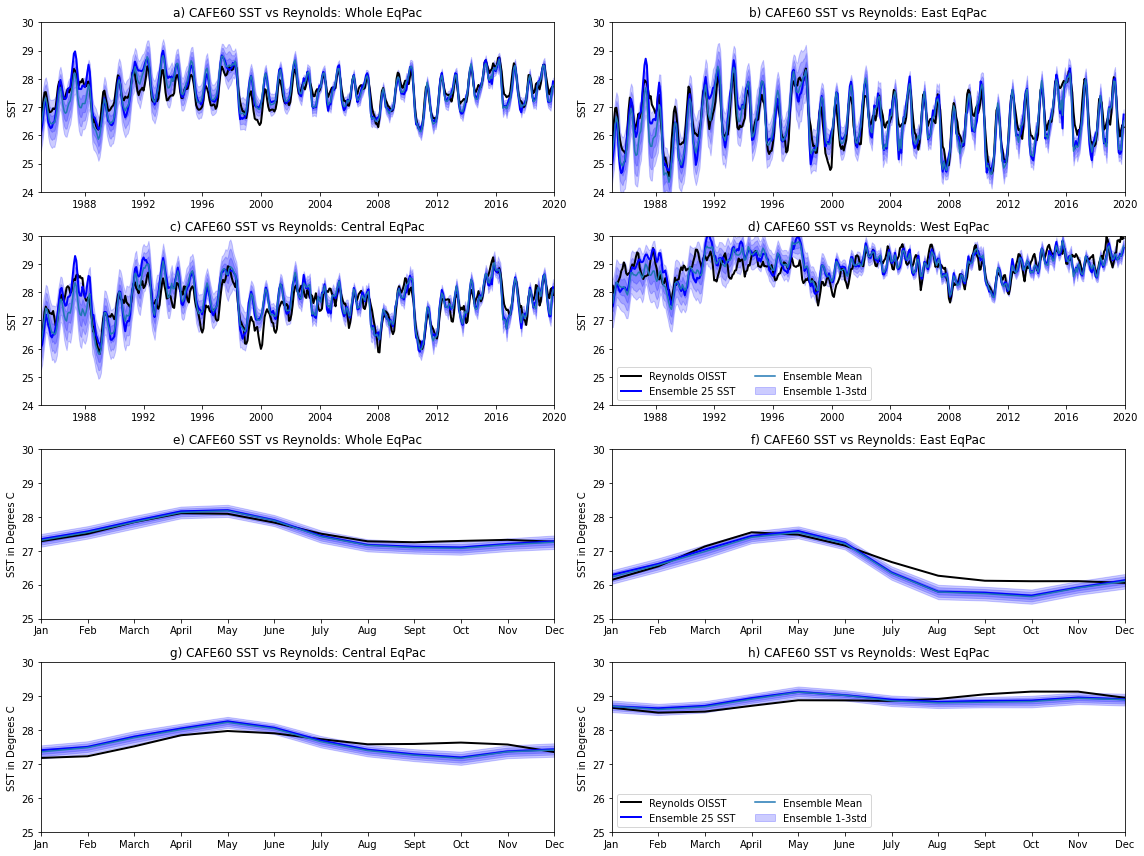

In [38]:
plt.figure(figsize=(16,12))
letters=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o']
all_err=[]
for i,latlon in enumerate(locs):
    #Conversion  #mmol/s to mol/s to mol/day to g/day and also invert for sea-air flux. Reg short for region.
    cafe_sst_std_reg=(cafe_sst_all).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).std(dim=['lat','lon'])
    cafe_sst_mean_reg=(cafe_sst_all).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    
    rey_sst_std_reg=((rey_sst.sst)).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).std(dim=['lat','lon'])
    rey_sst_mean_reg=((rey_sst.sst)).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    
    print('cafe SST: '+ str(cafe_sst_mean_reg.mean(dim=['time','ensemble']).sst.values))
    print('reynolds SST: '+str(rey_sst_mean_reg.mean(dim=['time']).values))
    
    err=cafe_sst_mean_reg.std(dim='ensemble').load()
    m=cafe_sst_mean_reg.mean(dim='ensemble').load()
    
    #if i==0:
    #    ax=plt.subplot(4,1,1)
    #else:
    #    ax=plt.subplot(4,3,3+i)
    ax=plt.subplot(4,2,i+1)
    
    ax.plot(rey_sst_mean_reg.time,rey_sst_mean_reg,c='k',linewidth=2)
    
        # Plot the Seemingly most accurate CO2 flux ens member
    ax.plot(cafe_sst_mean_reg.time,cafe_sst_mean_reg.sst.sel(ensemble=best_ensemble_member),c='b',linewidth=2)

    ax.plot(m.time,m.sst)
    ax.fill_between(err.time.values,m.sst+(err*1).sst,m.sst-(err*1).sst,alpha=0.2,color='blue')
    ax.fill_between(err.time.values,m.sst+(err*2).sst,m.sst-(err*2).sst,alpha=0.2,color='blue')
    ax.fill_between(err.time.values,m.sst+(err*3).sst,m.sst-(err*3).sst,alpha=0.2,color='blue')

    ax.set_xlim([np.datetime64('1985-01-01'),np.datetime64('2020-01-01')])

#    ax.legend(['Reynolds OISST','Ensemble 25 SST','Ensemble Mean and 1-3std']) #,
    if (i+1)%4==0:
        ax.legend(['Reynolds OISST','Ensemble 25 SST','Ensemble Mean','Ensemble 1-3std'],ncol=2) #,
    ax.set_xlim([np.datetime64('1985-01-01'),np.datetime64('2020-01-01')])
    ax.set_ylabel('SST')
    #ax.set_title('CO2 flux comparisons')
    ax.set_title(f'{letters[i]}) CAFE60 SST vs Reynolds: {labels[i]}')
    plt.ylim([24,30])

    
    #Calculate biases
    
    #These biases might be backwards.
    perc_err=(((cafe_sst_mean_reg.sst-rey_sst_mean_reg)/rey_sst_mean_reg)*100).mean(dim='time')
    bias=(cafe_sst_mean_reg.sst-rey_sst_mean_reg).mean(dim='time')
    mae=np.abs(cafe_sst_mean_reg.sst-rey_sst_mean_reg).mean(dim='time')
    
    print(labels[i]+' : '+str(perc_err.mean(dim='ensemble').values) + '% err')
    perc_err.name='percenterr'
    bias.name='bias'
    mae.name='mae'
    err_stats=xr.merge([perc_err,bias,mae],compat='override')
    err_stats['region']=i
    err_stats['region_name']=labels[i]
    all_err.append(err_stats)
    
regional_sst_err=xr.concat(all_err,dim='region')

#Where do we want to save results??
#regional_err.to_netcdf('/scratch1/pit071/CO2_flux_error.nc')
#plt.tight_layout()
#plt.show()
print(regional_sst_err)
regional_sst_err.to_netcdf('../processed_data/err/regional_sst_err.nc')


for i,latlon in enumerate(locs):
    #print(i)
    cafe_seasonality=cafe_sst_all.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).sst.groupby('time.month').mean()
 
    rey_seasonality=rey_sst.sst.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).groupby('time.month').mean().mean(dim=['lat','lon'])

    #if i==0:
    #    ax=plt.subplot(4,1,3)
    #else:
    #    ax=plt.subplot(4,3,9+i)
    ax=plt.subplot(4,2,5+i)    
    err=cafe_seasonality.std(dim='ensemble').mean(dim=['lat','lon']).load()
    m=cafe_seasonality.mean(['lat','lon','ensemble']).load()
    
    ax.plot(rey_seasonality.month,rey_seasonality,c='k',linewidth=2)
        # Plot the Seemingly most accurate CO2 flux ens member
    ax.plot(cafe_seasonality.month,cafe_seasonality.mean(['lat','lon']).sel(ensemble=best_ensemble_member),c='b',linewidth=2)
    
    ax.plot(err.month,m)
    ax.fill_between(err.month,m+(err*1),m-(err*1),alpha=0.2,color='blue')
    ax.fill_between(err.month,m+(err*2),m-(err*2),alpha=0.2,color='blue')
    ax.fill_between(err.month,m+(err*3),m-(err*3),alpha=0.2,color='blue')

    

    #Ok we could plot the individual lines using seaborn. 
    
    #land_seasonality=land_seasonality.to_dataframe().reset_index()
    #seasonal=cafe_seasonality.stf10.mean(dim=['lat','lon']).to_dataframe().reset_index()
    #sns.lineplot(data=seasonal,x='month',y='stf10',hue='ensemble',ax=ax)#,hue='ensemble')
    #sns.lineplot(data=land_seasonality,x='month',y='fgco2_smoothed',color='k',linewidth=3,ax=ax)#,hue='ensemble')
        
    ax.set_xlim([1,12])
    ax.set_ylabel('SST in Degrees C')
    plt.ylim([25,30])
    #ax.set_title('CAFE60 SST vs Reynolds SST: '+labels[i])
    
    ax.set_title(f'{letters[4+i]}) CAFE60 SST vs Reynolds: {labels[i]}')
    #plt.xticks(['Feb','April','June', 'August','October', 'December'])
    plt.xticks(ticks=np.arange(1,13,1),labels=['Jan','Feb','March','April','May','June','July', 'Aug','Sept','Oct','Nov', 'Dec'])
    if (i+1)%4==0:
        ax.legend(['Reynolds OISST','Ensemble 25 SST','Ensemble Mean','Ensemble 1-3std'],ncol=2) #,
    #ax.legend(['Landschutzer CO2','Rodenbeck CO2','Ensemble 25','Ensemble 25 Natural CO2','1-3std'])
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='ensemble'>

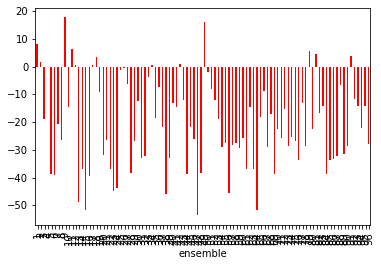

array([ 1,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
       85, 90, 95])

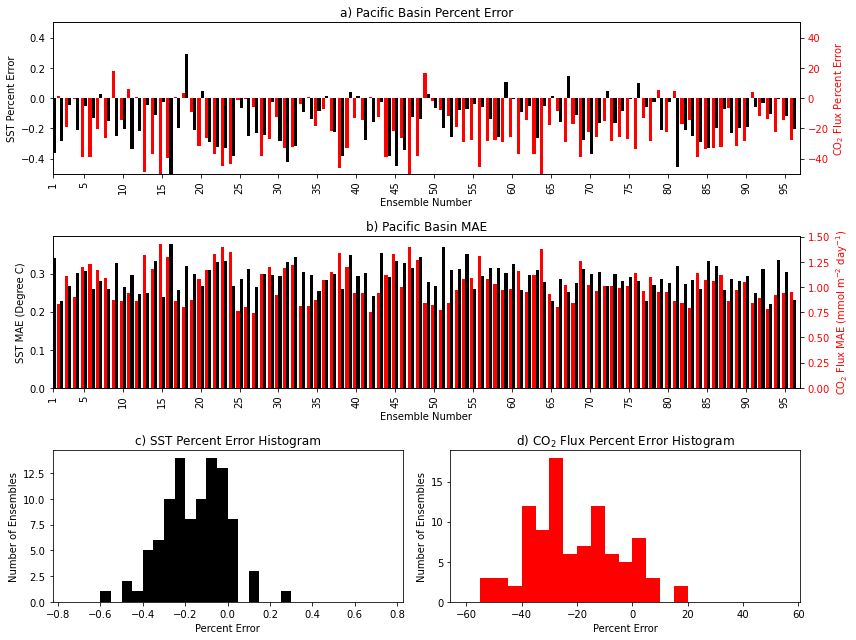

In [60]:
regional_sst_err=xr.open_dataset('../processed_data/err/regional_sst_err.nc')
regional_err = xr.open_dataset('../processed_data/err/regional_co2_err.nc')
region=0
plt.figure(figsize=(12,9))
models=np.arange(0,96,5)
models[0]=1

ax1=plt.subplot(311)
regional_sst_err.sel(region=region).percenterr.to_series().plot.bar(ax=ax1,position=0,color='k',width=0.4)
ax1.set_ylabel('SST Percent Error', color='k') 
plt.ylim([-0.5,0.5])

ax2 = ax1.twinx() 
regional_err.sel(region=region).percenterr.to_series().plot.bar(ax=ax2,color='red',position=1,width=0.4)
plt.title('')
ax2.set_ylabel('CO$_{2}$ Flux Percent Error', color='r') 
ax2.tick_params(axis='y', labelcolor='r')
#ax2.set_xlabel('Ensemble Number')
ax1.set_xlabel('Ensemble Number')
ax1.title.set_text('a) Pacific Basin Percent Error')
#ax2.title.set_text('Pacific Basin Percent Error')
plt.xlim([0,96])
plt.ylim([-50,50])
plt.xticks(ticks=models-1,labels=models)



ax3=plt.subplot(312)
regional_sst_err.sel(region=region).mae.to_series().plot.bar(ax=ax3,position=0,color='k',width=0.4)
ax3.set_ylabel('SST MAE (Degree C)', color='k') 

ax4 = ax3.twinx() 
regional_err.sel(region=region).mae.to_series().plot.bar(ax=ax4,position=1,color='r',width=0.4)
ax4.set_ylabel('CO$_{2}$ Flux MAE (mmol m$^{-2}$ day$^{-1}$)', color='r') 
ax4.tick_params(axis='y', labelcolor='r')

ax3.title.set_text('b) Pacific Basin MAE')
#ax3.title.set_text('Ensemble Number')

ax3.set_xlabel('Ensemble Number')
#ax3.set_title('Pacific Basin MAE')
plt.title('')
plt.xlim([0,96])
plt.xticks(ticks=models-1,labels=models)





ax4=plt.subplot(325)
regional_sst_err.sel(region=region).percenterr.to_series().plot.hist(ax=ax4,color='k',bins=np.arange(-0.75,0.76,0.05))
plt.title('c) SST Percent Error Histogram')
plt.ylabel('Number of Ensembles')
plt.xlabel('Percent Error')
ax5=plt.subplot(326)
regional_err.sel(region=region).percenterr.to_series().plot.hist(ax=ax5,color='r',bins=np.arange(-60,60,5))
plt.title('d) CO$_{2}$ Flux Percent Error Histogram')
plt.ylabel('Number of Ensembles')
plt.xlabel('Percent Error')
plt.tight_layout()
plt.show()

<AxesSubplot:ylabel='Frequency'>

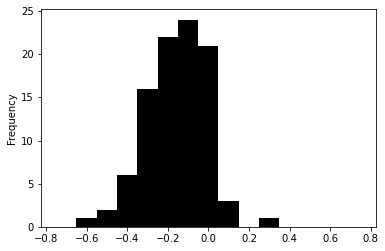

<AxesSubplot:ylabel='Frequency'>

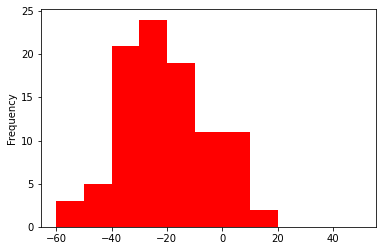

In [33]:
regional_err.sel(region=region).percenterr.to_series().plot.hist(color='r',bins=np.arange(-60,60,10))

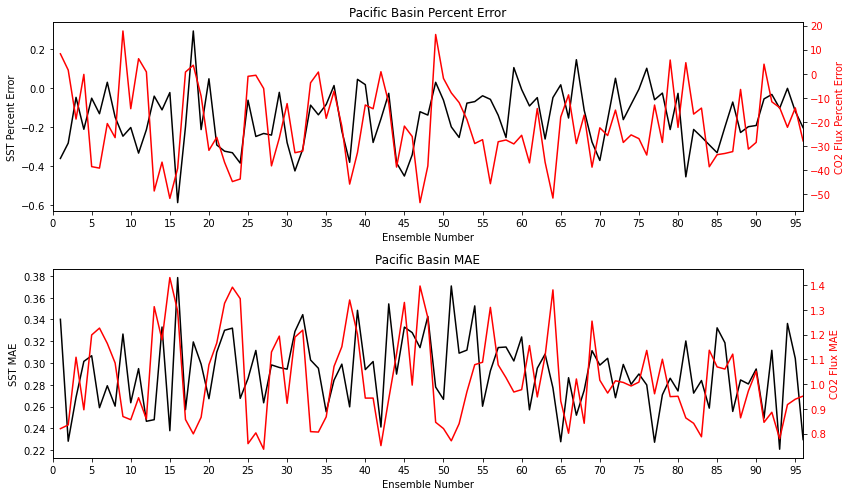

In [22]:
regional_sst_err=xr.open_dataset('../processed_data/err/regional_sst_err.nc')
regional_err = xr.open_dataset('../processed_data/err/regional_co2_err.nc')
region=0
plt.figure(figsize=(12,7))

ax1=plt.subplot(211)
regional_sst_err.sel(region=region).percenterr.plot(ax=ax1,c='k')
ax1.set_ylabel('SST Percent Error', color='k') 


ax2 = ax1.twinx() 
regional_err.sel(region=region).percenterr.plot(ax=ax2,c='r')
plt.title('')
ax2.set_ylabel('CO2 Flux Percent Error', color='r') 
ax2.tick_params(axis='y', labelcolor='r')
#ax2.set_xlabel('Ensemble Number')
ax1.set_xlabel('Ensemble Number')
ax1.title.set_text('Pacific Basin Percent Error')
#ax2.title.set_text('Pacific Basin Percent Error')
plt.xlim([0,96])
plt.xticks(np.arange(0, 96, 5))


ax3=plt.subplot(212)
regional_sst_err.sel(region=region).mae.plot(ax=ax3,c='k')
ax3.set_ylabel('SST MAE', color='k') 

ax4 = ax3.twinx() 
regional_err.sel(region=region).mae.plot(ax=ax4,c='r')
ax4.set_ylabel('CO2 Flux MAE', color='r') 
ax4.tick_params(axis='y', labelcolor='r')

ax3.title.set_text('Pacific Basin MAE')
#ax3.title.set_text('Ensemble Number')

ax3.set_xlabel('Ensemble Number')
#ax3.set_title('Pacific Basin MAE')
plt.title('')
plt.xlim([0,96])
plt.xticks(np.arange(0, 96, 5))
plt.tight_layout()
plt.show()